#### Introdução

Este Jupyter Notebook contém análises de influências relativas a parâmetros do processo de eletrofiação de nanofibras no diâmetro das nanofibras geradas com o copolímero poly(3-hydroxybutyrate-co-3-hydroxyhexanoate) – PHBHHx. Ele também contém modelagens matermáticas relativas a esse diâmetro com abordagens associadas ao contexto de Aprendizado de Máquina.

#### Definição de Métodos Utilizados nas Análises e nas Modelagens

In [88]:
# Importa pacotes e configura comportamentos gerais para este notebook
#
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats.mstats import kruskal
from scikit_posthocs import posthoc_dunn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from statistics import mean
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [89]:
# Define constantes básicas para este notebook como um todo
#
DIRETORIO_DADOS = "dados"
NUM_MEDIDAS_POR_EXPERIMENTO = 45
NUM_VALORES_POR_PARAMETRO = 3
NUM_PARAMETROS = 4
NUM_MEDIDAS_POR_SERIE = NUM_MEDIDAS_POR_EXPERIMENTO * NUM_VALORES_POR_PARAMETRO ** (
    NUM_PARAMETROS - 1
)
DIAMETRO = "Length"
PROPRIEDADE = "Diâmetro [micrometro]"
PARAMETROS = {
    "C": "Concentração [%p/v]",
    "F": "Fluxo [mL/h]",
    "D": "Distância [cm]",
    "V": "Voltagem [kV]",
}
VALORES_PARAMETROS = {
    "C": ["8 %", "10 %", "12 %"],
    "F": ["0,2 mL/h", "0,5 mL/h", "0,8 mL/h"],
    "D": ["15 cm", "17,5 cm", "20 cm"],
    "V": ["15 kV", "20 kV", "25 kV"],
}
SIGLAS_PARAMETROS = list(PARAMETROS.keys())
FIGSIZE = (6, 3)
FIGSIZE_MAIOR = (9, 5)
DEBUG = False
ALPHA = 0.05
TAXA_SPLIT = 0.4
NUM_TREINOS_TESTES = 10

In [90]:
# Retorna lista com nomes de todos os arquivos CSV em certo diretório
#
def carregue_nomes_arquivos_csv(diretorio):
    return glob.glob(os.path.join(diretorio, "*.csv"))

In [91]:
# Retorna lista com nomes de arquivos CSV que contêm certa string
#
def filtre_nomes_arquivos_csv(arquivos_csv, string):
    lista_filtrada = []
    for arquivo in arquivos_csv:
        if string in arquivo:
            lista_filtrada = lista_filtrada + [arquivo]
    if DEBUG:
        print("Lista filtrada com {} arquivos:".format(len(lista_filtrada)))
        print(*lista_filtrada, sep="\n")
    return lista_filtrada

In [92]:
# Retorna lista com os primeiros NUM_MEDIDAS_POR_EXPERIMENTO diâmetros
# contidos em certo arquivo CSV
#
def carregue_propriedades_de_arquivo(arquivo):
    # Carrega os diâmetros contidos no arquivo
    df = pd.read_csv(arquivo)
    propriedades = list(df[DIAMETRO].head(NUM_MEDIDAS_POR_EXPERIMENTO))
    if DEBUG:
        print("# propriedades carregados de {}: {}".format(arquivo, len(propriedades)))
    return propriedades

In [93]:
# Retorna lista com os primeiros NUM_MEDIDAS_POR_EXPERIMENTO diâmetros
# contidos em certos arquivos CSV
#
def carregue_propriedades_de_arquivos(arquivos):
    propriedades = []
    for arquivo in arquivos:
        propriedades = propriedades + carregue_propriedades_de_arquivo(arquivo)
    return propriedades

In [94]:
# Retorna DataFrame com os primeiros NUM_MEDIDAS_POR_EXPERIMENTO
# diâmetros contidos em arquivos CSV. São incluídos na coluna i do
# DataFrame apenas diâmetros de arquivos CSV cujos nomes têm certa
# sigla que revela certo parâmetro e foram gerados com o i-esimo
# valor atribuído a esse parâmetro
#
def carregue_propriedades_de_arquivos_por_param(arquivos, sigla_parametro):
    valores_parametros = VALORES_PARAMETROS[sigla_parametro]
    df = pd.DataFrame(
        columns=valores_parametros, index=np.arange(NUM_MEDIDAS_POR_SERIE)
    )
    valor_parametro_1 = valores_parametros[0]
    valor_parametro_2 = valores_parametros[1]
    valor_parametro_3 = valores_parametros[2]
    df[valor_parametro_1] = pd.Series(
        carregue_propriedades_de_arquivos(
            filtre_nomes_arquivos_csv(arquivos, sigla_parametro + "1")
        )
    )
    df[valor_parametro_2] = pd.Series(
        carregue_propriedades_de_arquivos(
            filtre_nomes_arquivos_csv(arquivos, sigla_parametro + "2")
        )
    )
    df[valor_parametro_3] = pd.Series(
        carregue_propriedades_de_arquivos(
            filtre_nomes_arquivos_csv(arquivos, sigla_parametro + "3")
        )
    )
    return df

In [95]:
# Plota boxplot com séries de diâmetros gerados com cada valor atribuído
# a certo parâmetro
# Teoria: Boxplot é uma representação gráfica não paramétrica que resume a
# distribuição de dados quantitativos, mostrando a mediana, quartis e
# outliers (se desejável)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
#
def crie_boxplot_por_param(df, sigla_parametro, propriedade):
    plt.figure(figsize=FIGSIZE)
    bp = df.boxplot(showfliers=False, return_type="dict")
    ax = plt.gca()
    for i, median_line in enumerate(bp["medians"]):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]
        ax.text(
            np.mean(x),
            median_value,
            f"{median_value:.3f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=9,
        )
    plt.title("Boxplot: {} x {}".format(propriedade, PARAMETROS[sigla_parametro]))
    plt.xticks(rotation=45)
    plt.ylabel(propriedade)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [96]:
# Plota Kernel Density Estimation (KDE) com séries  de diâmetros gerados com cada
# valor atribuído a certo parâmetro
# Teoria: KDE é um método não paramétrico que estima Probability Density Function (PDF)
# Ref 1: https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
# Ref 2: https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517/
#
def crie_kde_por_param(df, sigla_parametro, propriedade):
    plt.figure(figsize=FIGSIZE)
    sns.kdeplot(data=df.iloc[:, 0], label=df.columns[0], alpha=0.1, fill=True)
    sns.kdeplot(data=df.iloc[:, 1], label=df.columns[1], alpha=0.1, fill=True)
    sns.kdeplot(data=df.iloc[:, 2], label=df.columns[2], alpha=0.1, fill=True)
    plt.title("KDE: {} x {}".format(propriedade, PARAMETROS[sigla_parametro]))
    plt.xlabel(propriedade, fontsize=10)
    plt.ylabel("Densidade", fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [97]:
# Aplica Teste H de Kruskal-Wallis nas séries (grupos) de diâmetros gerados com cada valor
# atribuído a certo parâmetro
# Teoria: Teste H de Kruskal-Wallis é um método estatístico não paramétrico utilizado para
# detectar diferenças entre 3 ou mais grupos independentes
# Ref 1: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.kruskalwallis.html
# Ref 2: https://www.blog.psicometriaonline.com.br/teste-de-kruskal-wallis/
#
def aplique_teste_kruskal_wallis(df):
    _, p_value = kruskal(*[df[col].values for col in df.columns])
    sig = "sim" if p_value < ALPHA else "não"
    print("Resultados do Teste H de Kruskal-Wallis:")
    print("\tP-value: {}".format(p_value))
    print("\tSignificativo (α < {}): {}".format(ALPHA, sig))

In [98]:
# Aplica Teste post hoc de Dunn nas séries de diâmetros gerados com cada valor atribuído
# a certo parâmetro
# Teoria: Teste post hoc de Dunn realiza comparações múltiplas de somas de classificações médias.
# Indicado ser utilizado após Teste H de Kruskal-Wallis
# Ref 1: https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
# Ref 2: https://www.blog.psicometriaonline.com.br/o-que-e-um-teste-post-hoc/
#
def aplique_teste_posthoc_dunn(df):
    g1 = df.iloc[:, 0].values
    g2 = df.iloc[:, 1].values
    g3 = df.iloc[:, 2].values
    dunn_results = posthoc_dunn([g1, g2, g3], p_adjust="holm")
    plt.figure(figsize=FIGSIZE)
    mask = np.triu(np.ones_like(dunn_results, dtype=bool))
    sns.heatmap(
        dunn_results,
        annot=True,
        cmap="RdYlBu",
        mask=mask,
        vmin=0,
        vmax=1,
        center=0.5,
        xticklabels=df.columns,
        yticklabels=df.columns,
    )
    plt.title("Resultados do Teste post hoc de Dunn (P-values)")
    plt.tight_layout()
    plt.show()

In [99]:
# Realiza estudo sobre certo parâmetro e retorna o DataFrame carregado
#
def realize_estudo_por_param(arquivos, sigla_parametro, propriedade):
    df = carregue_propriedades_de_arquivos_por_param(arquivos, sigla_parametro)
    print("Estatísticas gerais relativas aos diâmetros considerados:")
    display(pd.melt(df).describe())
    print("Estatísticas estratificadas relativas aos diâmetros considerados:")
    display(df.describe())
    crie_boxplot_por_param(df, sigla_parametro, propriedade)
    crie_kde_por_param(df, sigla_parametro, propriedade)
    aplique_teste_kruskal_wallis(df)
    aplique_teste_posthoc_dunn(df)
    return df

In [100]:
# Gera dicionário com valores de parâmetros referentes a certo arquivo CSV
#
def gere_valores_parametros_de_arquivo(arquivo):
    parametros = os.path.splitext(os.path.basename(arquivo))[0].split("_")
    dicionario_valores_parametros = {}
    for parametro in parametros:
        sigla_parametro = parametro[0]
        valor_parametro = float(
            VALORES_PARAMETROS[sigla_parametro][int(parametro[1]) - 1]
            .split()[0]
            .replace(",", ".")
        )
        dicionario_valores_parametros[sigla_parametro] = [valor_parametro]
    return dicionario_valores_parametros

In [101]:
# Gera matriz Xy referente a certo arquivo CSV
#
def gere_matriz_xy_de_arquivo(arquivo, propriedade):
    propriedades = carregue_propriedades_de_arquivo(arquivo)
    valores_parametros = gere_valores_parametros_de_arquivo(arquivo)
    valores_parametros[propriedade] = mean(propriedades)
    return pd.DataFrame(valores_parametros)

In [102]:
# Gera matriz Xy referente a certos arquivos CSV
#
def gere_matriz_xy_de_arquivos(arquivos, propriedade):
    Xy = pd.DataFrame()
    for arquivo in arquivos:
        Xy = pd.concat([Xy, gere_matriz_xy_de_arquivo(arquivo, propriedade)])
    return Xy

In [103]:
# Gera matrizes para serem usadas em treino e teste de modelos
#
def gere_matrizes_treino_teste(Xy, propriedade, random_state):
    Xy_treino, Xy_teste = train_test_split(Xy, test_size=TAXA_SPLIT, random_state=random_state)
    X_treino = Xy_treino[SIGLAS_PARAMETROS]
    y_treino = Xy_treino[propriedade]
    X_teste = Xy_teste[SIGLAS_PARAMETROS]
    y_teste = Xy_teste[propriedade]
    return X_treino, y_treino, X_teste, y_teste

In [104]:
# Plota boxplot com resultados de certa métrica em treino e teste
# Teoria: Boxplot é uma representação gráfica não paramétrica que resume a
# distribuição de dados quantitativos, mostrando a mediana, quartis e
# outliers (se desejável)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
#
def crie_boxplot_por_metrica(df_metricas, titulo):
    plt.figure(figsize=FIGSIZE_MAIOR)
    bp = df_metricas.boxplot(showfliers=False, return_type="dict")
    ax = plt.gca()
    for i, median_line in enumerate(bp["medians"]):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]
        ax.text(
            np.mean(x),
            median_value,
            f"{median_value:.3f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=9,
        )
    plt.title("Boxplot: {}".format(titulo))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

#### Carregamento dos Arquivos com Dados Utilizados na Análises e nas Modelagens

In [105]:
# Carrega nomes de todos os arquivos CSV em DIRETORIO_DADOS
#
ARQUIVOS_CSV = carregue_nomes_arquivos_csv(DIRETORIO_DADOS)

#### 1ª Análise: Influência do 1o Parâmetro (Concentração) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (concentração) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que algum valor de concentração tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Concentração de 8% tende a resultar diâmetros diferentes de 10% e 12%;
    * Concentração de 10% tende a resultar diâmetros diferentes de 12%.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,8 %,10 %,12 %
count,1215.000000,1215.000000,1215.000000
mean,2.905578,2.743295,3.181787
std,0.913389,0.844380,0.971826
min,0.497000,0.666000,1.093000
25%,2.275000,2.113000,2.450000
50%,2.906000,2.706000,3.022000
75%,3.511000,3.243000,3.686000
max,6.790000,6.511000,7.881000


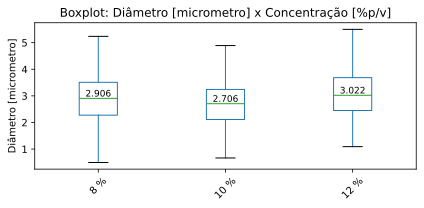

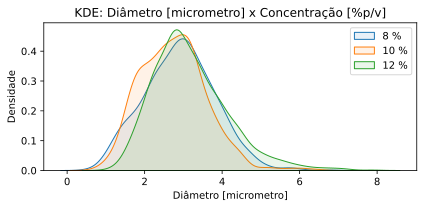

Resultados do Teste H de Kruskal-Wallis:
	P-value: 1.6090292273459537e-24
	Significativo (α < 0.05): sim


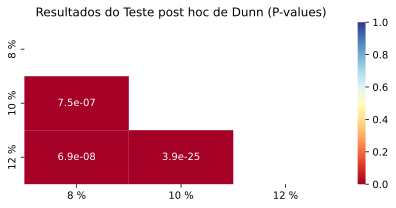

In [106]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[0]
df_estudo_1 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### 2ª Análise: Influência do 2o Parâmetro (Fluxo) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (fluxo) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que algum valor de fluxo tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Fluxo de 0,2 mL/h tende a resultar diâmetros diferentes de 0,8 mL/h;
    * Fluxo de 0,2 mL/h tende a **NÃO** resultar diâmetros diferentes de 0,5 mL/h;
    * Fluxo de 0,5 mL/h tende a resultar diâmetros diferentes de 0,8 mL/h.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,"0,2 mL/h","0,5 mL/h","0,8 mL/h"
count,1215.000000,1215.000000,1215.000000
mean,2.962021,3.012972,2.855666
std,0.928607,0.961207,0.889361
min,0.666000,0.497000,1.103000
25%,2.329500,2.367000,2.227000
50%,2.953000,2.943000,2.747000
75%,3.532000,3.504000,3.338000
max,7.881000,7.125000,7.223000


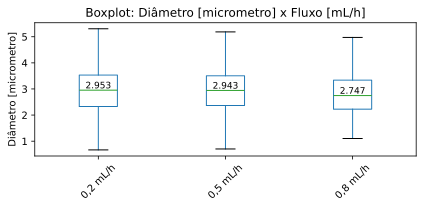

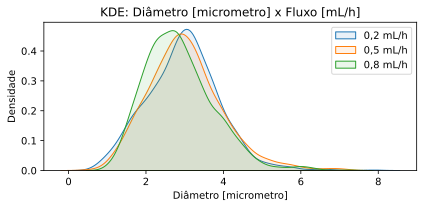

Resultados do Teste H de Kruskal-Wallis:
	P-value: 1.0262589442822639e-05
	Significativo (α < 0.05): sim


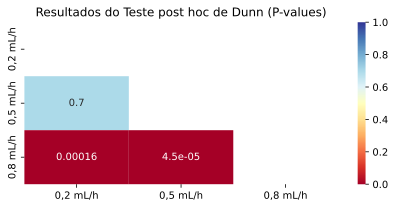

In [107]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[1]
df_estudo_2 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### 3ª Análise: Influência do 3o Parâmetro (Distância) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (distância) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que **NENHUM** valor de distância tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Distância de 15 cm tende a **NÃO** resultar diâmetros diferentes de 17,5 cm;
    * Distância de 15 cm tende a **NÃO** resultar diâmetros diferentes de 20 cm;
    * Distância de 17,5 cm tende a **NÃO** resultar diâmetros diferentes de 20 cm.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,15 cm,"17,5 cm",20 cm
count,1215.000000,1215.000000,1215.000000
mean,2.917756,2.958981,2.953922
std,0.942686,0.926915,0.917195
min,0.772000,0.981000,0.497000
25%,2.231000,2.319500,2.319000
50%,2.840000,2.904000,2.904000
75%,3.504000,3.499000,3.476000
max,7.125000,7.104000,7.881000


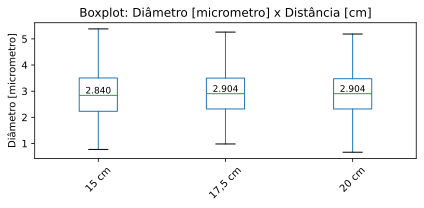

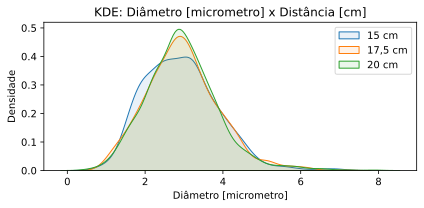

Resultados do Teste H de Kruskal-Wallis:
	P-value: 0.34728094559719697
	Significativo (α < 0.05): não


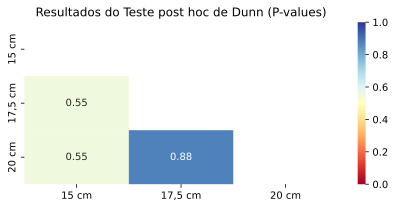

In [108]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[2]
df_estudo_3 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### 4ª Análise: Influência do 4o Parâmetro (Voltagem) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (voltagem) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que algum valor de voltagem tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Voltagem de 15 kV tende a resultar diâmetros diferentes de 20 kV e 25 kV;
    * Voltagem de 20 kV tende a resultar diâmetros diferentes de 25 kV.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,15 kV,20 kV,25 kV
count,1215.000000,1215.000000,1215.000000
mean,3.101477,2.721698,3.007485
std,0.891221,0.865713,0.983891
min,0.772000,0.497000,0.832000
25%,2.533500,2.012000,2.325000
50%,3.094000,2.732000,2.904000
75%,3.563000,3.322000,3.563000
max,7.881000,6.595000,7.223000


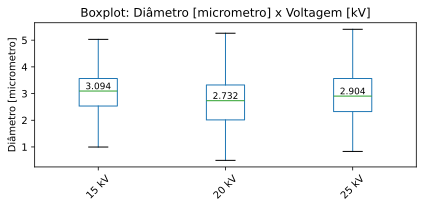

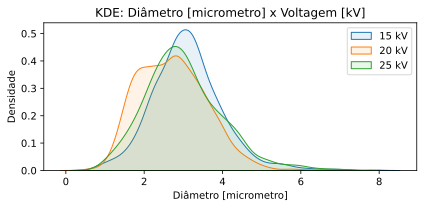

Resultados do Teste H de Kruskal-Wallis:
	P-value: 1.9654998271964065e-25
	Significativo (α < 0.05): sim


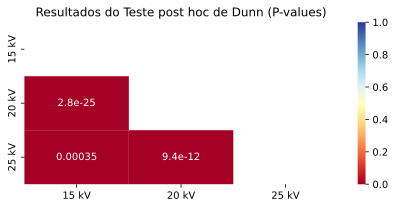

In [109]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[3]
df_estudo_4 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### Modelagens Matemáticas para o Diâmetro

In [110]:
# Fixa semente para reprodutibilidade deste estudo como um todo
#
random.seed(4)

In [111]:
# Gera matriz Xy a partir de arquivos CSV (uma única vez!)
#
Xy = gere_matriz_xy_de_arquivos(ARQUIVOS_CSV, PROPRIEDADE)

# Gera matriz X (com transformação Z) e vetor y a partir da matriz Xy
#
scaler = StandardScaler()
X_hiper = Xy[SIGLAS_PARAMETROS]
y_hiper = Xy[PROPRIEDADE]
colunas = X_hiper.columns
X_hiper = pd.DataFrame(scaler.fit_transform(X_hiper))
X_hiper.columns = colunas

In [112]:
# Busca hiperparâmetros para modelo Ridge Regression
# 
estimator = Ridge()
parameters = {"alpha": [1, 10, 100, 1000]}
gs = GridSearchCV(estimator, parameters, scoring="r2", refit=False, cv=10)
gs.fit(X_hiper, y_hiper)
print("R-Quadrado médios de teste: {}".format(gs.cv_results_["mean_test_score"]))
print("Melhores hiperparâmetros: {}".format(gs.best_params_))

R-Quadrado médios de teste: [-0.29945189 -0.27229065 -0.22010529 -0.22927219]
Melhores hiperparâmetros: {'alpha': 100}


In [113]:
# Busca hiperparâmetros para modelo Lasso Regression (Linear Regression)
# 
estimator = Lasso()
parameters = {"alpha": np.linspace(0.1, 1.0, num=100)}
gs = GridSearchCV(estimator, parameters, scoring="r2", refit=False, cv=10)
gs.fit(X_hiper, y_hiper)
print("R-Quadrado médios de teste: {}".format(gs.cv_results_["mean_test_score"]))
print("Melhores hiperparâmetros: {}".format(gs.best_params_))

R-Quadrado médios de teste: [-0.23216637 -0.23745368 -0.23651638 -0.23523588 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.2345630

In [114]:
# Busca hiperparâmetros para modelo Lasso Regression (Polynomial Regression)
# 
polyf = PolynomialFeatures(degree=2, include_bias=False)
X_hiper_poly = polyf.fit_transform(X_hiper)  # Inclui features polinomiais
estimator = Lasso()
parameters = {"alpha": np.linspace(0.1, 1.0, num=100)}
gs = GridSearchCV(estimator, parameters, scoring="r2", refit=False, cv=10)
gs.fit(X_hiper_poly, y_hiper)
print("R-Quadrado médios de teste: {}".format(gs.cv_results_["mean_test_score"]))
print("Melhores hiperparâmetros: {}".format(gs.best_params_))

R-Quadrado médios de teste: [-0.15361732 -0.17876955 -0.18687745 -0.19678213 -0.2083092  -0.21805492
 -0.22709167 -0.23343502 -0.23445326 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307 -0.23456307
 -0.23456307 -0.2345630

In [115]:
# Busca hiperparâmetros para modelo Random Forest Regression
# 
estimator = RandomForestRegressor()
parameters = {"max_depth": [2, 3, 4, 5], "n_estimators": [10, 30, 60, 90, 120, 150, 200, 250]}
gs = GridSearchCV(estimator, parameters, scoring="r2", refit=False, cv=10)
gs.fit(X_hiper, y_hiper)
print("R-Quadrado médios de teste: {}".format(gs.cv_results_["mean_test_score"]))
print("Melhores hiperparâmetros: {}".format(gs.best_params_))

R-Quadrado médios de teste: [-0.10201779 -0.13685375 -0.08763813 -0.12766074 -0.0767682  -0.07621264
 -0.090966   -0.09312757 -0.12889796 -0.08994687 -0.01270391 -0.02644816
 -0.04498623  0.00484211 -0.02916697 -0.01396209 -0.17517813 -0.13378203
 -0.08932518 -0.06179418 -0.06122569 -0.07705313 -0.07744708 -0.06231334
 -0.23574421 -0.2107601  -0.1956515  -0.10007586 -0.13509639 -0.1468993
 -0.14618326 -0.13470732]
Melhores hiperparâmetros: {'max_depth': 3, 'n_estimators': 150}


In [116]:
# Busca hiperparâmetros para modelo MLP Regression
#
estimator = MLPRegressor(random_state=4)
parameters = {
    "hidden_layer_sizes": [
        (5),
        (10),
        (20),
        (5, 5),
        (10, 5),
        (20, 5),
        (5, 10),
        (10, 10),
        (20, 10),
        (5, 20),
        (10, 20),
        (50, 50),
        (100, 100),
        (5, 5, 5),
        (5, 5, 10),
        (5, 5, 20),
        (5, 10, 5),
        (5, 10, 10),
        (5, 10, 20),        
        (5, 20, 5),
        (5, 20, 10),
        (5, 20, 20),
    ]
}
gs = GridSearchCV(estimator, parameters, scoring="r2", cv=10)
gs.fit(X_hiper, y_hiper)
print("R-Quadrado médios de teste: {}".format(gs.cv_results_["mean_test_score"]))
print("Melhores hiperparâmetros: {}".format(gs.best_params_))

R-Quadrado médios de teste: [-26.3216229  -11.01612334  -4.76854031  -5.45680436  -2.44787861
 -24.34460653  -5.96509894  -1.31477621  -1.92667166  -3.41555089
  -1.33867842  -0.86176721  -0.8095211   -4.67591856  -4.14219177
  -1.6193901   -3.18001395  -3.17376136  -3.67170859  -5.16410329
  -2.66271363  -1.56302041]
Melhores hiperparâmetros: {'hidden_layer_sizes': (100, 100)}


In [117]:
# Inicializa modelos considerados, alguns com melhores hiperparâmetros localizados
# 
linr = LinearRegression()
ridr = Ridge(alpha=1000)
laslr = Lasso(alpha=0.1)
laspr = Lasso(alpha=0.1)
randfr = RandomForestRegressor(max_depth = 3, n_estimators = 120)
mlpr = MLPRegressor(hidden_layer_sizes=(100, 100), random_state=4)

Resultados particulares dos modelos considerados:
	Parâmetros médios dos modelos Linear Regression:
		[0.1014335688811754, -0.018283449702261485, 0.015051088459213144, -0.03794075979538858]
	Parâmetros médios dos modelos Ridge Regression:
		[0.004672029307859769, -0.000558280037738949, 0.0006422791926253309, -0.0015323168078490168]
	Parâmetros médios dos modelos Lasso Regression (Linear Regression):
		[0.01797153146507551, 0.0, 0.0, -0.0018977937190630752]
	Parâmetros médios dos modelos Polynomial Regression:
		[0.09686781367313575, -0.005874546053282366, 0.021260078919195794, -0.03106850792372373, 0.22226534632948927, 0.03613439171308047, 0.04702310927467567, -0.027243138936459785, -0.058989184583307125, 0.009561570058216052, 0.16841365877557954, -0.038952909215905815, -0.11697888704983399, 0.18848838830520906]
	Parâmetros médios dos modelos Lasso Regression (Polynomial Regression):
		[0.014654612629123346, 0.0, 0.0, -0.0015654333731125792, 0.028968100976513818, 0.0, 0.0, -0.002204619

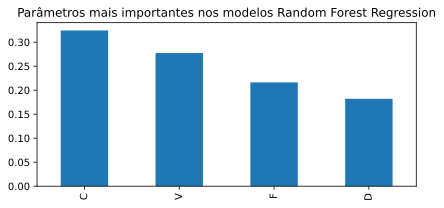

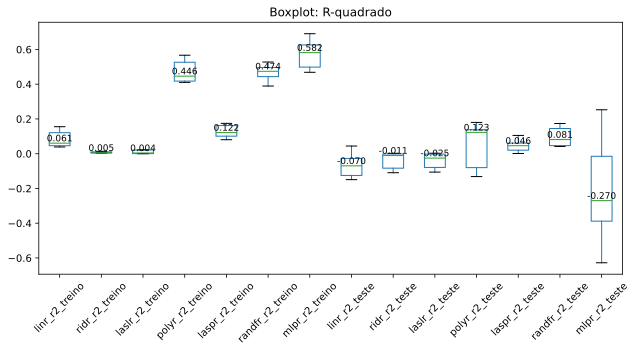

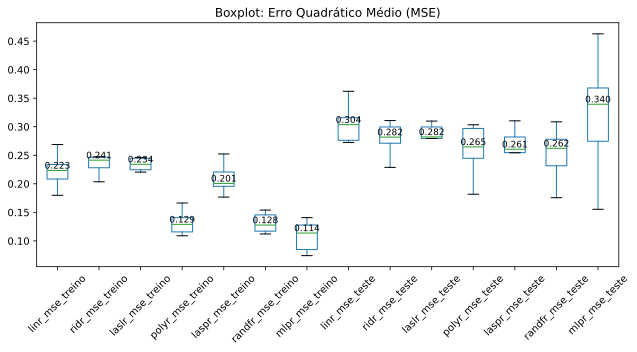

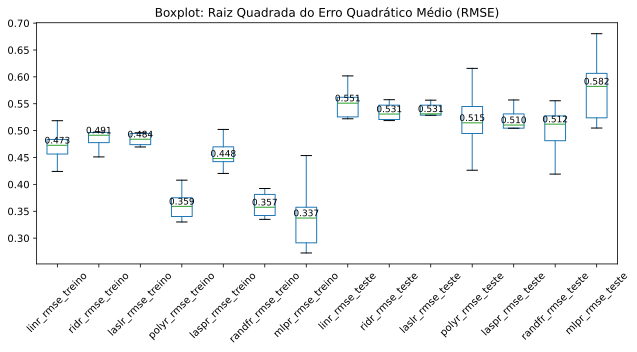

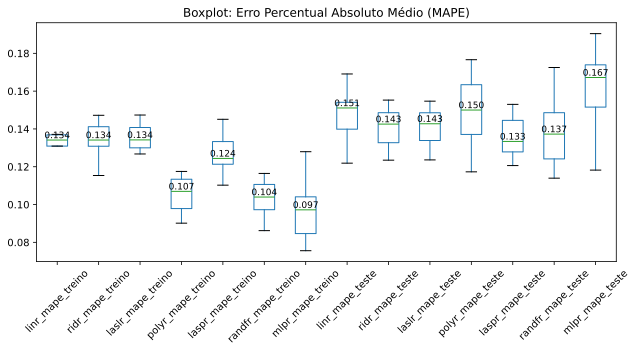

In [118]:
# Inicializa listas que armazenam métricas de cada modelo em cada treino e teste
#
linr_coefs = []
linr_r2_treino = []
linr_r2_teste = []
linr_mse_treino = []
linr_mse_teste = []
linr_rmse_treino = []
linr_rmse_teste = []
linr_mape_treino = []
linr_mape_teste = []

ridr_coefs = []
ridr_r2_treino = []
ridr_r2_teste = []
ridr_mse_treino = []
ridr_mse_teste = []
ridr_rmse_treino = []
ridr_rmse_teste = []
ridr_mape_treino = []
ridr_mape_teste = []

laslr_coefs = []
laslr_r2_treino = []
laslr_r2_teste = []
laslr_mse_treino = []
laslr_mse_teste = []
laslr_rmse_treino = []
laslr_rmse_teste = []
laslr_mape_treino = []
laslr_mape_teste = []

polyr_coefs = []
polyr_r2_treino = []
polyr_r2_teste = []
polyr_mse_treino = []
polyr_mse_teste = []
polyr_rmse_treino = []
polyr_rmse_teste = []
polyr_mape_treino = []
polyr_mape_teste = []

laspr_coefs = []
laspr_r2_treino = []
laspr_r2_teste = []
laspr_mse_treino = []
laspr_mse_teste = []
laspr_rmse_treino = []
laspr_rmse_teste = []
laspr_mape_treino = []
laspr_mape_teste = []

randfr_fis = []
randfr_r2_treino = []
randfr_r2_teste = []
randfr_mse_treino = []
randfr_mse_teste = []
randfr_rmse_treino = []
randfr_rmse_teste = []
randfr_mape_treino = []
randfr_mape_teste = []

mlpr_fis = []
mlpr_r2_treino = []
mlpr_r2_teste = []
mlpr_mse_treino = []
mlpr_mse_teste = []
mlpr_rmse_treino = []
mlpr_rmse_teste = []
mlpr_mape_treino = []
mlpr_mape_teste = []

# Realiza múltiplos treinos e testes com os modelos considerados
#
for tt in range(NUM_TREINOS_TESTES):
    # Gera matrizes para treino e teste aleatórias a partir da matriz Xy
    #
    X_treino, y_treino, X_teste, y_teste = gere_matrizes_treino_teste(Xy, PROPRIEDADE, tt)

    # Aplica transformada Z (aprende no conjunto de treino e aplica no de teste)
    #
    colunas = X_treino.columns
    X_treino = pd.DataFrame(scaler.fit_transform(X_treino))
    X_teste = pd.DataFrame(scaler.transform(X_teste))
    X_treino.columns = X_teste.columns = colunas

    # Treina, testa e calcula métricas para Linear Regression
    #
    resultados = linr.fit(X_treino, y_treino)
    y_treino_pred = linr.predict(X_treino)
    y_teste_pred = linr.predict(X_teste)
    linr_coefs.append(linr.coef_.tolist())
    linr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    linr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    linr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    linr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    linr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    linr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    linr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    linr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

    # Treina, testa e calcula métricas para Ridge Regression
    #
    resultados = ridr.fit(X_treino, y_treino)
    y_treino_pred = ridr.predict(X_treino)
    y_teste_pred = ridr.predict(X_teste)
    ridr_coefs.append(ridr.coef_.tolist())
    ridr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    ridr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    ridr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    ridr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    ridr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    ridr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    ridr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    ridr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

    # Treina, testa e calcula métricas para Lasso Regression (Linear Regression)
    #
    resultados = laslr.fit(X_treino, y_treino)
    y_treino_pred = laslr.predict(X_treino)
    y_teste_pred = laslr.predict(X_teste)
    laslr_coefs.append(laslr.coef_.tolist())
    laslr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    laslr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    laslr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    laslr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    laslr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    laslr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    laslr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    laslr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

    # Cria matrizes com features polinomiais
    #
    X_treino_poly = polyf.fit_transform(X_treino)
    X_teste_poly = polyf.transform(X_teste)

    # Treina, testa e calcula métricas para Polynomial Regression
    #
    resultados = linr.fit(X_treino_poly, y_treino)  # Utiliza modelo Linear Regression
    y_treino_pred = linr.predict(X_treino_poly)  # Utiliza modelo Linear Regression
    y_teste_pred = linr.predict(X_teste_poly)  # Utiliza modelo Linear Regression
    polyr_coefs.append(linr.coef_.tolist())
    polyr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    polyr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    polyr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    polyr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    polyr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    polyr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    polyr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    polyr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

    # Treina, testa e calcula métricas para Lasso Regression (Polynomial Regression)
    #
    resultados = laspr.fit(X_treino_poly, y_treino)
    y_treino_pred = laspr.predict(X_treino_poly)
    y_teste_pred = laspr.predict(X_teste_poly)
    laspr_coefs.append(laspr.coef_.tolist())
    laspr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    laspr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    laspr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    laspr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    laspr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    laspr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    laspr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    laspr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

    # Treina, testa e calcula métricas para Random Forest Regression
    #
    resultados = randfr.fit(X_treino, y_treino)
    y_treino_pred = randfr.predict(X_treino)
    y_teste_pred = randfr.predict(X_teste)
    randfr_fis.append(randfr.feature_importances_)
    randfr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    randfr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    randfr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    randfr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    randfr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    randfr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    randfr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    randfr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

    # Treina, testa e calcula métricas para MLP Regression
    #
    resultados = mlpr.fit(X_treino, y_treino)
    y_treino_pred = mlpr.predict(X_treino)
    y_teste_pred = mlpr.predict(X_teste)
    mlpr_r2_treino.append(r2_score(y_treino, y_treino_pred))
    mlpr_r2_teste.append(r2_score(y_teste, y_teste_pred))
    mlpr_mse_treino.append(mean_squared_error(y_treino, y_treino_pred))
    mlpr_mse_teste.append(mean_squared_error(y_teste, y_teste_pred))
    mlpr_rmse_treino.append(root_mean_squared_error(y_treino, y_treino_pred))
    mlpr_rmse_teste.append(root_mean_squared_error(y_teste, y_teste_pred))
    mlpr_mape_treino.append(mean_absolute_percentage_error(y_treino, y_treino_pred))
    mlpr_mape_teste.append(mean_absolute_percentage_error(y_teste, y_teste_pred))

print("Resultados particulares dos modelos considerados:")
print("\tParâmetros médios dos modelos Linear Regression:")
print("\t\t{}".format(list(map(mean, zip(*linr_coefs)))))
print("\tParâmetros médios dos modelos Ridge Regression:")
print("\t\t{}".format(list(map(mean, zip(*ridr_coefs)))))
print("\tParâmetros médios dos modelos Lasso Regression (Linear Regression):")
print("\t\t{}".format(list(map(mean, zip(*laslr_coefs)))))
print("\tParâmetros médios dos modelos Polynomial Regression:")
print("\t\t{}".format(list(map(mean, zip(*polyr_coefs)))))
print("\tParâmetros médios dos modelos Lasso Regression (Polynomial Regression):")
print("\t\t{}".format(list(map(mean, zip(*laspr_coefs)))))
feature_importances = list(map(mean, zip(*randfr_fis)))
fi = pd.Series(feature_importances, index=X_treino.columns).sort_values(ascending=False)
plt.figure(figsize=FIGSIZE)
fi.plot.bar()
plt.title("Parâmetros mais importantes nos modelos Random Forest Regression")
plt.tight_layout()
plt.show()

# Encapsula métricas a serem retornadas por esta função
#
metricas = {
    "linr_r2_treino": linr_r2_treino,
    "linr_r2_teste": linr_r2_teste,
    "linr_mse_treino": linr_mse_treino,
    "linr_mse_teste": linr_mse_teste,
    "linr_rmse_treino": linr_rmse_treino,
    "linr_rmse_teste": linr_rmse_teste,
    "linr_mape_treino": linr_mape_treino,
    "linr_mape_teste": linr_mape_teste,
    "ridr_r2_treino": ridr_r2_treino,
    "ridr_r2_teste": ridr_r2_teste,
    "ridr_mse_treino": ridr_mse_treino,
    "ridr_mse_teste": ridr_mse_teste,
    "ridr_rmse_treino": ridr_rmse_treino,
    "ridr_rmse_teste": ridr_rmse_teste,
    "ridr_mape_treino": ridr_mape_treino,
    "ridr_mape_teste": ridr_mape_teste,
    "laslr_r2_treino": laslr_r2_treino,
    "laslr_r2_teste": laslr_r2_teste,
    "laslr_mse_treino": laslr_mse_treino,
    "laslr_mse_teste": laslr_mse_teste,
    "laslr_rmse_treino": laslr_rmse_treino,
    "laslr_rmse_teste": laslr_rmse_teste,
    "laslr_mape_treino": laslr_mape_treino,
    "laslr_mape_teste": laslr_mape_teste,
    "polyr_r2_treino": polyr_r2_treino,
    "polyr_r2_teste": polyr_r2_teste,
    "polyr_mse_treino": polyr_mse_treino,
    "polyr_mse_teste": polyr_mse_teste,
    "polyr_rmse_treino": polyr_rmse_treino,
    "polyr_rmse_teste": polyr_rmse_teste,
    "polyr_mape_treino": polyr_mape_treino,
    "polyr_mape_teste": polyr_mape_teste,
    "laspr_r2_treino": laspr_r2_treino,
    "laspr_r2_teste": laspr_r2_teste,
    "laspr_mse_treino": laspr_mse_treino,
    "laspr_mse_teste": laspr_mse_teste,
    "laspr_rmse_treino": laspr_rmse_treino,
    "laspr_rmse_teste": laspr_rmse_teste,
    "laspr_mape_treino": laspr_mape_treino,
    "laspr_mape_teste": laspr_mape_teste,
    "randfr_r2_treino": randfr_r2_treino,
    "randfr_r2_teste": randfr_r2_teste,
    "randfr_mse_treino": randfr_mse_treino,
    "randfr_mse_teste": randfr_mse_teste,
    "randfr_rmse_treino": randfr_rmse_treino,
    "randfr_rmse_teste": randfr_rmse_teste,
    "randfr_mape_treino": randfr_mape_treino,
    "randfr_mape_teste": randfr_mape_teste,
    "mlpr_r2_treino": mlpr_r2_treino,
    "mlpr_r2_teste": mlpr_r2_teste,
    "mlpr_mse_treino": mlpr_mse_treino,
    "mlpr_mse_teste": mlpr_mse_teste,
    "mlpr_rmse_treino": mlpr_rmse_treino,
    "mlpr_rmse_teste": mlpr_rmse_teste,
    "mlpr_mape_treino": mlpr_mape_treino,
    "mlpr_mape_teste": mlpr_mape_teste,
}
metricas = pd.DataFrame(metricas)

# Cria boxplots
#
crie_boxplot_por_metrica(
    metricas[
        [
            "linr_r2_treino",
            "ridr_r2_treino",
            "laslr_r2_treino",
            "polyr_r2_treino",
            "laspr_r2_treino",
            "randfr_r2_treino",
            "mlpr_r2_treino",
            "linr_r2_teste",
            "ridr_r2_teste",
            "laslr_r2_teste",
            "polyr_r2_teste",
            "laspr_r2_teste",
            "randfr_r2_teste",
            "mlpr_r2_teste",
        ]
    ],
    "R-quadrado",
)
crie_boxplot_por_metrica(
    metricas[
        [
            "linr_mse_treino",
            "ridr_mse_treino",
            "laslr_mse_treino",
            "polyr_mse_treino",
            "laspr_mse_treino",
            "randfr_mse_treino",
            "mlpr_mse_treino",
            "linr_mse_teste",
            "ridr_mse_teste",
            "laslr_mse_teste",
            "polyr_mse_teste",
            "laspr_mse_teste",
            "randfr_mse_teste",
            "mlpr_mse_teste",
        ]
    ],
    "Erro Quadrático Médio (MSE)",
)
crie_boxplot_por_metrica(
    metricas[
        [
            "linr_rmse_treino",
            "ridr_rmse_treino",
            "laslr_rmse_treino",
            "polyr_rmse_treino",
            "laspr_rmse_treino",
            "randfr_rmse_treino",
            "mlpr_rmse_treino",
            "linr_rmse_teste",
            "ridr_rmse_teste",
            "laslr_rmse_teste",
            "polyr_rmse_teste",
            "laspr_rmse_teste",
            "randfr_rmse_teste",
            "mlpr_rmse_teste",
        ]
    ],
    "Raiz Quadrada do Erro Quadrático Médio (RMSE)",
)
crie_boxplot_por_metrica(
    metricas[
        [
            "linr_mape_treino",
            "ridr_mape_treino",
            "laslr_mape_treino",
            "polyr_mape_treino",
            "laspr_mape_treino",
            "randfr_mape_treino",
            "mlpr_mape_treino",
            "linr_mape_teste",
            "ridr_mape_teste",
            "laslr_mape_teste",
            "polyr_mape_teste",
            "laspr_mape_teste",
            "randfr_mape_teste",
            "mlpr_mape_teste",
        ]
    ],
    "Erro Percentual Absoluto Médio (MAPE)",
)